# Image Segmentation with U-Net

This notebook is the implementatuion of the building of U-Net, a type of CNN designed for quick, precise image segemntation, and using it to predict a label for every single pixel in an image. In this case, an image from a self-driving car dataset.

This type of image classification is called semantic image segmentation. It's similar to object detection in that both ask the question: "What objects are in this image and where in the image are those objects located?," but where object detection labels objects with bounding boxes that may include pixels that aren't part of the object, semantic image segmentation allows you to predict a precise mask for each object in the image by labeling each pixel in the image with its corresponding class. The word “semantic” here refers to what's being shown, so for example the “Car” class is indicated below by the dark blue mask, and "Person" is indicated with a red mask:

<img src="images/carseg.png" style="width:500px;height:250;">

## Packages

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import imageio
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Conv2DTranspose, concatenate

## Load and Split the Data

In [2]:
path = ''
image_path = os.path.join(path, './data/CameraRGB/')
mask_path = os.path.join(path, './data/CameraMask/')
image_list_orig = os.listdir(image_path)
image_list = [image_path+i for i in image_list_orig]
mask_list = [mask_path+i for i in image_list_orig]

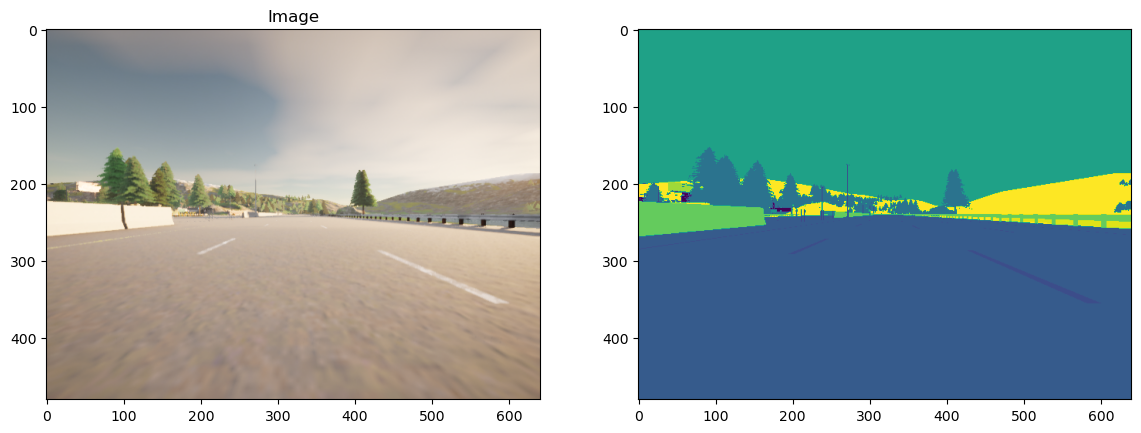

In [3]:
N = 2
img = imageio.v3.imread(image_list[N])
mask = imageio.v3.imread(mask_list[N])

fig, arr = plt.subplots(1, 2, figsize=(14, 10))
arr[0].imshow(img)
arr[0].set_title('Image')
arr[1].imshow(mask[:, :, 0])

### Splitting the Dataset into Unmasked and Masked Images

In [4]:
image_list_ds = tf.data.Dataset.list_files(image_list, shuffle=False)
mask_list_ds = tf.data.Dataset.list_files(mask_list, shuffle=False)

for path in zip(image_list_ds.take(3), mask_list_ds.take(3)):
    print(path)

(<tf.Tensor: shape=(), dtype=string, numpy=b'.\\data\\CameraRGB\\000026.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'.\\data\\CameraMask\\000026.png'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'.\\data\\CameraRGB\\000027.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'.\\data\\CameraMask\\000027.png'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'.\\data\\CameraRGB\\000028.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'.\\data\\CameraMask\\000028.png'>)


In [5]:
image_filenames = tf.constant(image_list)
masks_filenames = tf.constant(mask_list)

dataset = tf.data.Dataset.from_tensor_slices((image_filenames, masks_filenames))

for image, mask in dataset.take(1):
    print(image)
    print(mask)

tf.Tensor(b'./data/CameraRGB/000026.png', shape=(), dtype=string)
tf.Tensor(b'./data/CameraMask/000026.png', shape=(), dtype=string)


### Preprocess the Data

In [6]:
def process_path(image_path, mask_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=3)
    mask = tf.math.reduce_max(mask, axis=-1, keepdims=True)
    return img, mask

def preprocess(image, mask):
    input_image = tf.image.resize(image, (96, 128), method='nearest')
    input_mask = tf.image.resize(mask, (96, 128), method='nearest')

    return input_image, input_mask

image_ds = dataset.map(process_path)
processed_image_ds = image_ds.map(preprocess)

## U-Net 

U-Net, named for its U-shape, was originally created in 2015 for tumor detection, but in the years since has become a very popular choice for other semantic segmentation tasks. 

U-Net builds on a previous architecture called the Fully Convolutional Network, or FCN, which replaces the dense layers found in a typical CNN with a transposed convolution layer that upsamples the feature map back to the size of the original input image, while preserving the spatial information. This is necessary because the dense layers destroy spatial information (the "where" of the image), which is an essential part of image segmentation tasks. An added bonus of using transpose convolutions is that the input size no longer needs to be fixed, as it does when dense layers are used. 

Unfortunately, the final feature layer of the FCN suffers from information loss due to downsampling too much. It then becomes difficult to upsample after so much information has been lost, causing an output that looks rough. 

U-Net improves on the FCN, using a somewhat similar design, but differing in some important ways.  Instead of one transposed convolution at the end of the network, it uses a matching number of convolutions for downsampling the input image to a feature map, and transposed convolutions for upsampling those maps back up to the original input image size. It also adds skip connections, to retain information that would otherwise become lost during encoding. Skip connections send information to every upsampling layer in the decoder from the corresponding downsampling layer in the encoder, capturing finer information while also keeping computation low. These help prevent information loss, as well as model overfitting. 

### Model Details

<img src="images/unet.png" style="width:700px;height:400;">
<caption><center> <u><b> Figure 2 </u></b>: U-Net Architecture<br> </center></caption>

**Contracting path** (Encoder containing downsampling steps):

Images are first fed through several convolutional layers which reduce height and width, while growing the number of channels.

The contracting path follows a regular CNN architecture, with convolutional layers, their activations, and pooling layers to downsample the image and extract its features. In detail, it consists of the repeated application of two 3 x 3 same padding convolutions, each followed by a rectified linear unit (ReLU) and a 2 x 2 max pooling operation with stride 2 for downsampling. At each downsampling step, the number of feature channels is doubled.

**Crop function**: This step crops the image from the contracting path and concatenates it to the current image on the expanding path to create a skip connection. 

**Expanding path** (Decoder containing upsampling steps):

The expanding path performs the opposite operation of the contracting path, growing the image back to its original size, while shrinking the channels gradually.

In detail, each step in the expanding path upsamples the feature map, followed by a 2 x 2 convolution (the transposed convolution). This transposed convolution halves the number of feature channels, while growing the height and width of the image.

Next is a concatenation with the correspondingly cropped feature map from the contracting path, and two 3 x 3 convolutions, each followed by a ReLU. You need to perform cropping to handle the loss of border pixels in every convolution.

**Final Feature Mapping Block**: In the final layer, a 1x1 convolution is used to map each 64-component feature vector to the desired number of classes. The channel dimensions from the previous layer correspond to the number of filters used, so when you use 1x1 convolutions, you can transform that dimension by choosing an appropriate number of 1x1 filters. When this idea is applied to the last layer, you can reduce the channel dimensions to have one layer per class. 

The U-Net network has 23 convolutional layers in total.

### Encoder (Downsampling Block) 

<img src="images/encoder.png" style="width:500px;height:500;">
<caption><center> <u><b>Figure 3</u></b>: The U-Net Encoder up close <br> </center></caption>

The encoder is a stack of various conv_blocks:

Each `conv_block()` is composed of 2 **Conv2D** layers  with ReLU activations. We will apply **Dropout**, and **MaxPooling2D** to some conv_blocks, as you will verify in the following sections, specifically to the last two blocks of the downsampling. 

The function will  return two tensors: 
- `next_layer`: That will go into the next block. 
- `skip_connection`: That will go into the corresponding decoding block.

**Note**: If `max_pooling=True`, the `next_layer` will be the output of the MaxPooling2D layer, but the `skip_connection` will be the output of the previously applied layer(Conv2D or Dropout, depending on the case). Else, both results will be identical.

In [7]:
def conv_block(inputs=None, n_filters=32, dropout_prob=0, max_pooling=True):
    conv = Conv2D(n_filters, 3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    conv = Conv2D(n_filters,3, activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    
    if dropout_prob > 0:
        conv = Dropout(dropout_prob)(conv)
         
    if max_pooling:
        next_layer = MaxPooling2D(2)(conv)
        
    else:
        next_layer = conv
        
    skip_connection = conv
    
    return next_layer, skip_connection

### Decoder (Upsampling Block)

The decoder, or upsampling block, upsamples the features back to the original image size. At each upsampling level, you'll take the output of the corresponding encoder block and concatenate it before feeding to the next decoder block.

<img src="images/decoder.png" style="width:500px;height:500;">
<caption><center> <u><b>Figure 4</u></b>: The U-Net Decoder up close <br> </center></caption>

There are two new components in the decoder: `up` and `merge`. These are the transpose convolution and the skip connections. In addition, there are two more convolutional layers set to the same parameters as in the encoder.

In [8]:
def upsampling_block(expansive_input, contractive_input, n_filters=32):
    up = Conv2DTranspose(n_filters, 3, strides=2, padding='same')(expansive_input)
    merge = concatenate([up, contractive_input], axis=3)
    conv = Conv2D(n_filters, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge)
    conv = Conv2D(n_filters, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    
    return conv

In [9]:
def unet_model(input_size=(96, 128, 3), n_filters=32, n_classes=23):
    inputs = Input(input_size)
    
    cblock1 = conv_block(inputs=inputs, n_filters=n_filters * 1)
    cblock2 = conv_block(inputs=cblock1[0], n_filters=n_filters * 2)
    cblock3 = conv_block(inputs=cblock2[0], n_filters=n_filters * 4)
    cblock4 = conv_block(inputs=cblock3[0], n_filters=n_filters * 8, dropout_prob=0.3) # Include a dropout_prob of 0.3 for this layer
    cblock5 = conv_block(inputs=cblock4[0], n_filters=n_filters * 16, dropout_prob=0.3, max_pooling=False) 
    
    ublock6 = upsampling_block(cblock5[0], cblock4[1],  n_filters * 8)
    ublock7 = upsampling_block(ublock6, cblock3[1], n_filters * 4)
    ublock8 = upsampling_block(ublock7, cblock2[1], n_filters * 2)
    ublock9 = upsampling_block(ublock8, cblock1[1], n_filters * 1)

    conv9 = Conv2D(n_filters, 3, activation='relu', padding='same', kernel_initializer='he_normal')(ublock9)
    conv10 = Conv2D(n_classes, 1, padding='same')(conv9)
    
    model = tf.keras.Model(inputs=inputs, outputs=conv10)

    return model

### Set Model Dimensions

In [10]:
img_height = 96
img_width = 128
num_channels = 3

unet = unet_model((img_height, img_width, num_channels))

In [11]:
unet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 96, 128, 3)]         0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 96, 128, 32)          896       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 96, 128, 32)          9248      ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 48, 64, 32)           0         ['conv2d_1[0][0]']            
 D)                                                                                           

 conv2d_19 (Conv2D)          (None, 96, 128, 23)          759       ['conv2d_18[0][0]']           
                                                                                                  
Total params: 8640471 (32.96 MB)
Trainable params: 8640471 (32.96 MB)
Non-trainable params: 0 (0.00 Byte)
__________________________________________________________________________________________________


### Loss Function

In [12]:
unet.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

###  Dataset Handling

(480, 640, 1)


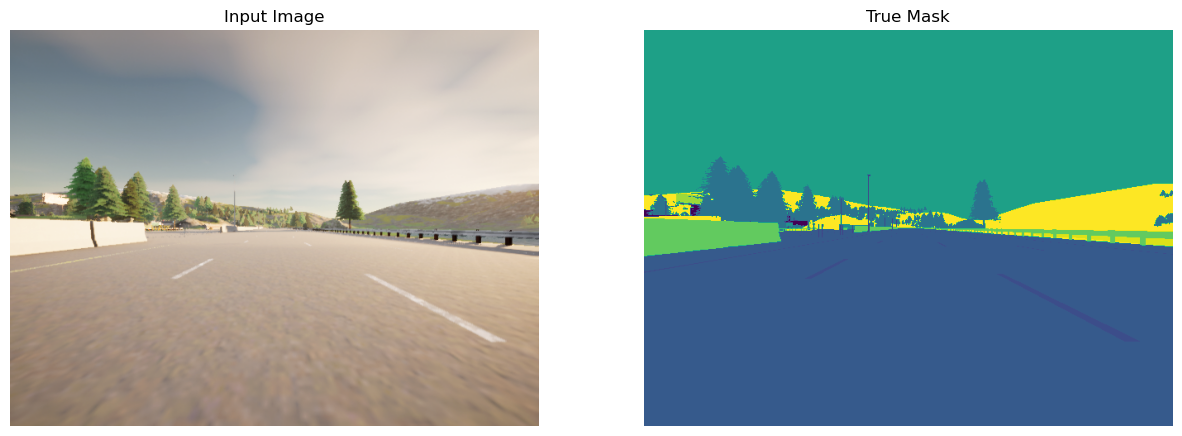

In [13]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()
    

for image, mask in image_ds.take(1):
    sample_image, sample_mask = image, mask
    print(mask.shape)
display([sample_image, sample_mask])

## Train the Model

In [14]:
EPOCHS = 10
VAL_SUBSPLITS = 5
BUFFER_SIZE = 500
BATCH_SIZE = 32
train_dataset = processed_image_ds.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
print(processed_image_ds.element_spec)
model_history = unet.fit(train_dataset, epochs=EPOCHS)

(TensorSpec(shape=(96, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(96, 128, 1), dtype=tf.uint8, name=None))
Epoch 1/10
34/34 [==============================] - 253s 7s/step - loss: 1.6894 - accuracy: 0.5380
Epoch 2/10
34/34 [==============================] - 230s 7s/step - loss: 0.7332 - accuracy: 0.8018
Epoch 3/10
34/34 [==============================] - 233s 7s/step - loss: 0.5853 - accuracy: 0.8256
Epoch 4/10
34/34 [==============================] - 231s 7s/step - loss: 0.4949 - accuracy: 0.8528
Epoch 5/10
34/34 [==============================] - 229s 7s/step - loss: 0.4244 - accuracy: 0.8734
Epoch 6/10
34/34 [==============================] - 230s 7s/step - loss: 0.3694 - accuracy: 0.8886
Epoch 7/10
34/34 [==============================] - 228s 7s/step - loss: 0.3216 - accuracy: 0.9028
Epoch 8/10
34/34 [==============================] - 230s 7s/step - loss: 0.2775 - accuracy: 0.9175
Epoch 9/10
34/34 [==============================] - 226s 7s/step - loss: 0.2584 - accur

### Create Predicted Mask

In [15]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

### Plot Model Accuracy

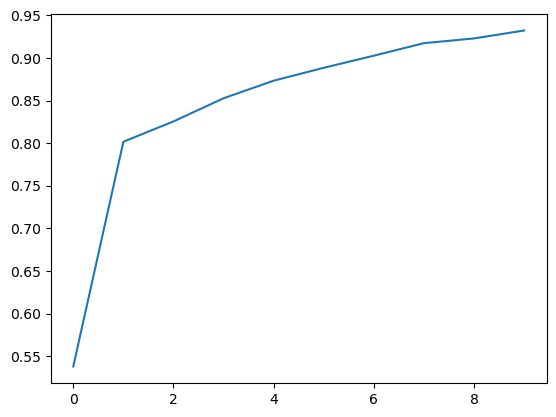

In [16]:
plt.plot(model_history.history["accuracy"])

## Predictions

1/1 [==============================] - 3s 3s/step


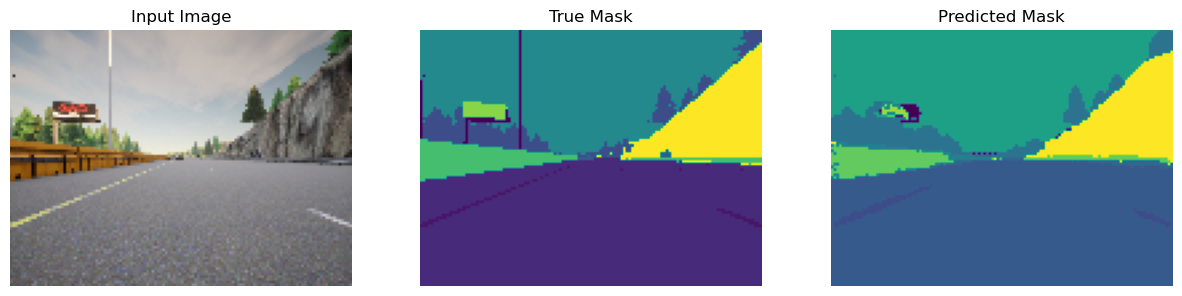

1/1 [==============================] - 2s 2s/step


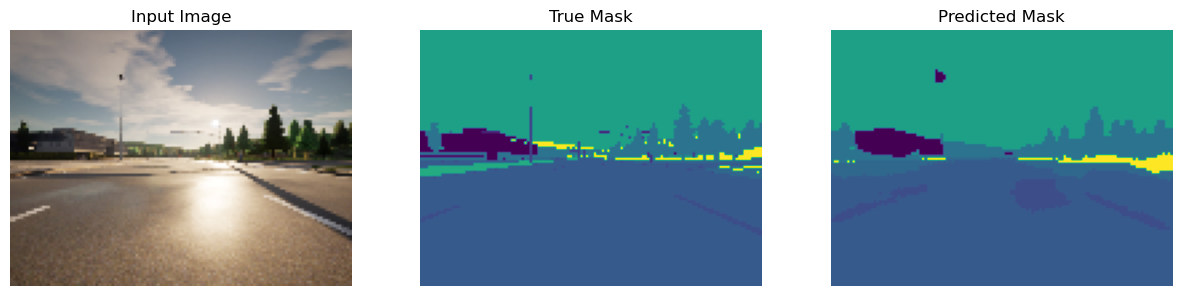

1/1 [==============================] - 2s 2s/step


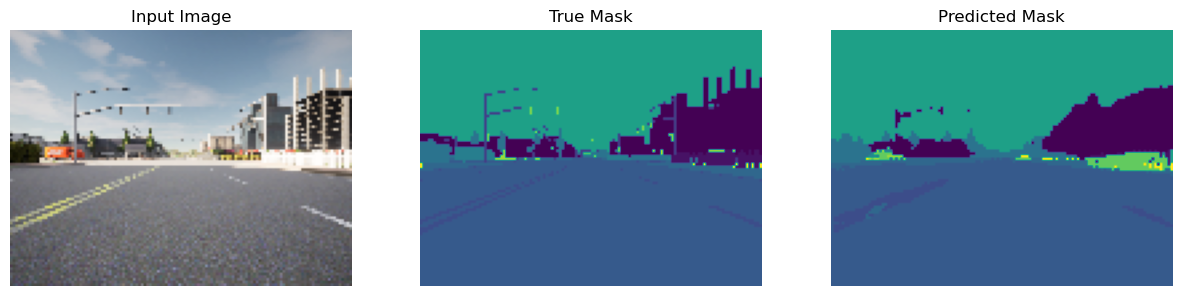

1/1 [==============================] - 2s 2s/step


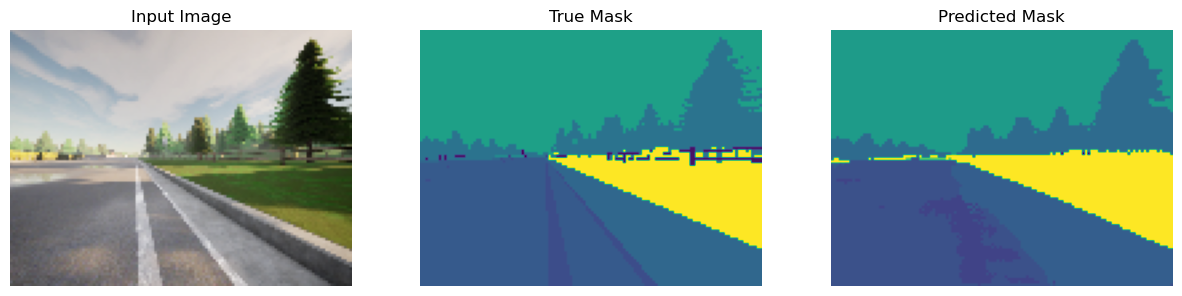

1/1 [==============================] - 2s 2s/step


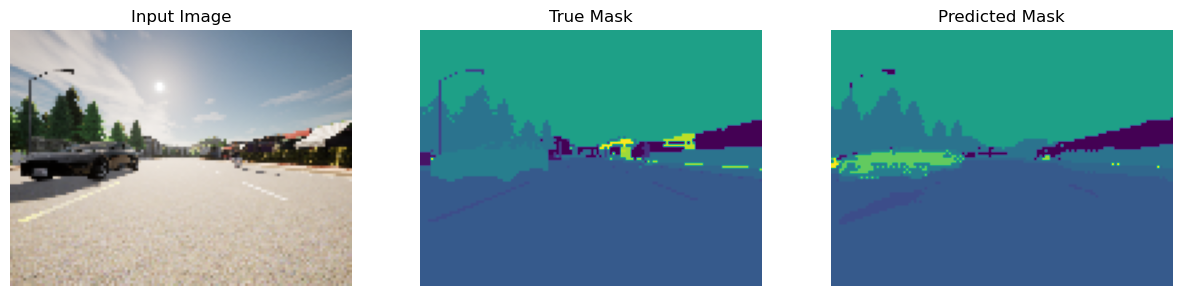

1/1 [==============================] - 2s 2s/step


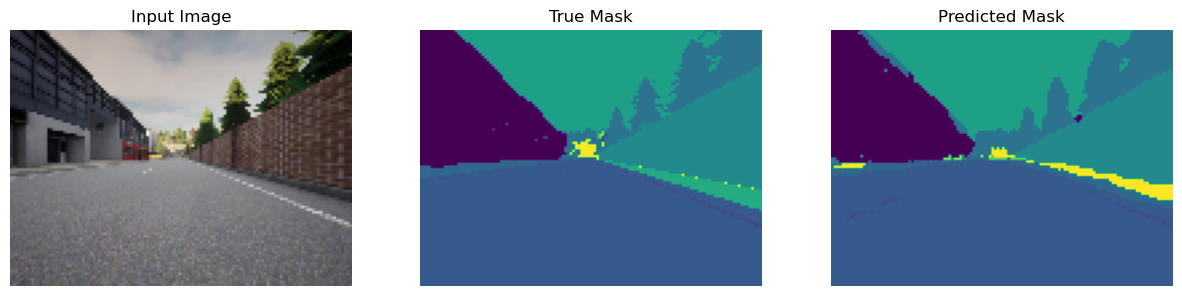

In [17]:
def show_predictions(dataset=None, num=1):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = unet.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
             create_mask(unet.predict(sample_image[tf.newaxis, ...]))])
        

show_predictions(train_dataset, 6)